<a href="https://colab.research.google.com/github/Rakeshscode/Data-Science/blob/main/Copy_of_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [2]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [3]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [4]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

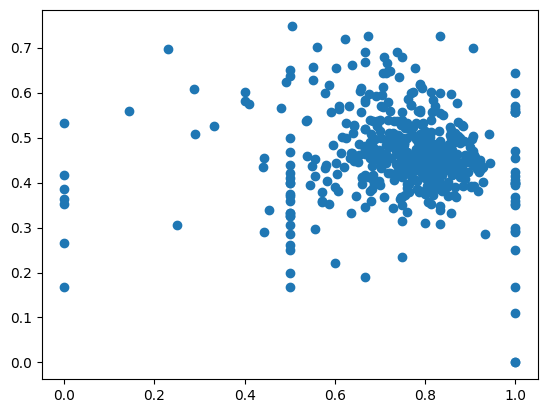

In [5]:
plt.scatter(basketball['FT%'] , basketball['FG%'],)

The scatter plot shows a strong mode around FT% 0.7–0.8 and FG% 0.4–0.6, representing typical efficiency levels for balanced shooters. Outside this cluster, there are three additional large modes at FT% 0, 0.5, and 1, likely stemming from players who either played fewer than 400 minutes or have a perfect FT%. These extremes are likely due to a small sample size, where the percentages don’t reflect the players’ true abilities due to the rule of large numbers not applying.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

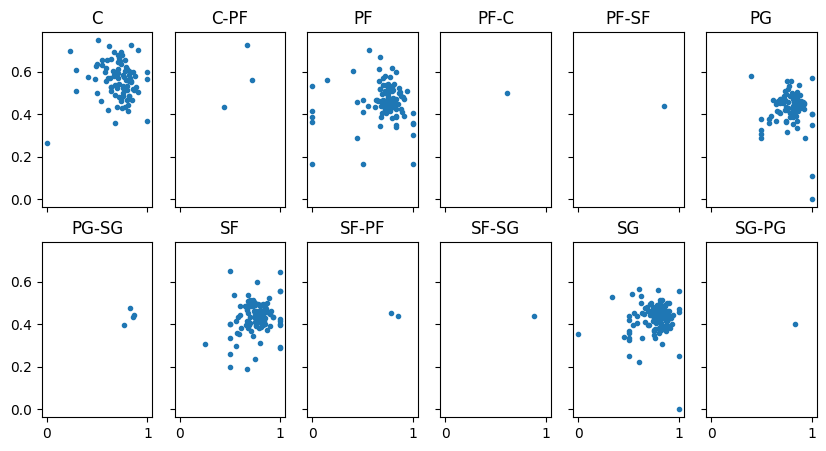

In [6]:
# Convert position labels into integer codes
position_indices = basketball.Pos.cat.codes.values

# Extract the string labels for positions
position_labels = basketball.Pos.cat.categories

# Create a dictionary to store coordinates for PyMC
basketball_coords = {"position": position_labels}

# Set up the subplots for visualization
fig, axes = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
axes = axes.flatten()

# Generate scatter plots for each position
for index, position in enumerate(position_labels):
    position_data = basketball.query('Pos == @position')
    axes[index].scatter(
        position_data['FT%'],
        position_data['FG%'],
        marker="."
    )
    axes[index].set_title(f"{position}")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

The regression model likely fails due to sparse data in certain categories and clustering in relationships, creating conflicting signals. Vertical lines in the data may stem from players with limited minutes (e.g., less than 400), leading to simplified values like 0, 0.5, or 1 for metrics like free throw percentage, which distort trends and affect slopes. Combined with the model being told to capture both positive (e.g., C) and negative (e.g., SF) correlations, this introduces contradictory patterns (e.g., C-SF) and instability, preventing the model from running effectively.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [7]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [8]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

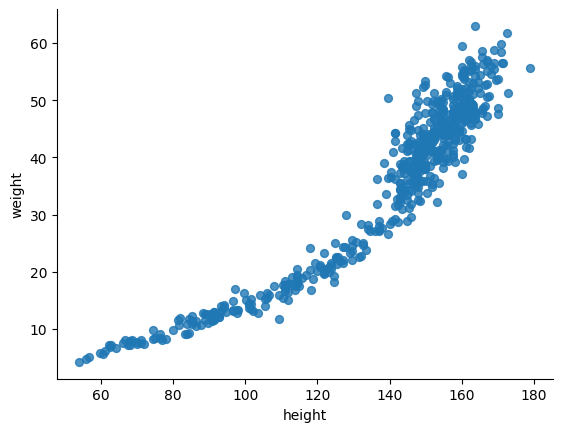

In [10]:
from matplotlib import pyplot as plt
howell.plot(kind='scatter', x='height', y='weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [12]:
with pm.Model() as model_new:

    # Priors for our mean line
    # Setting default mean for normal distribution at 0
    intercept = pm.Normal("intercept", sigma=10)
    slope = pm.Normal("slope", sigma=10)

    # Mean line equation
    mean_line = pm.Deterministic("mean_line", intercept + slope * howell.height)

    # Prior for standard deviation
    scale = pm.HalfNormal("scale", sigma=10)

    # Normal likelihood
    y_predicted = pm.Normal("y_predicted", mu=mean_line, sigma=scale, observed=howell.weight)

    idata_new = pm.sample()

Output()

Output()

Text(0, 0.5, 'weight')

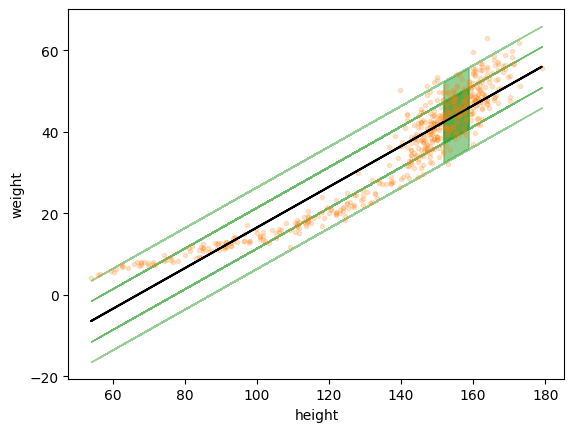

In [13]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C1.", alpha=0.2)

posterior_data = az.extract(idata_new)

mean_line_values = posterior_data["mean_line"].mean("sample").values
scale_values = posterior_data["scale"].mean("sample").values

ax.plot(howell.height, mean_line_values, c="k")
ax.fill_between(howell.height, mean_line_values + 1 * scale_values, mean_line_values - 1 * scale_values, alpha=0.7, color="C2")
ax.fill_between(howell.height, mean_line_values + 2 * scale_values, mean_line_values - 2 * scale_values, alpha=0.5, color="C2")

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [14]:
pm.sample_posterior_predictive(
    idata_new, model=model_new, extend_inferencedata=True
)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'weight')

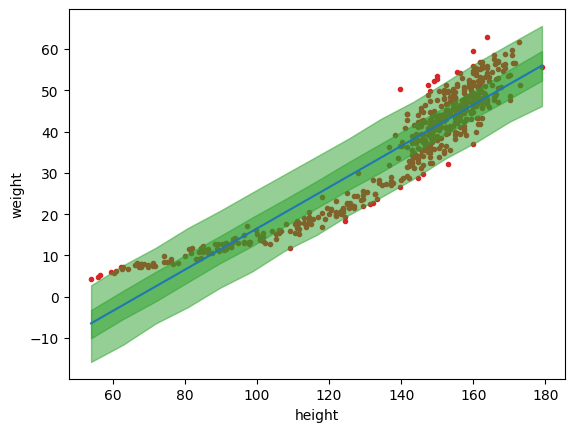

In [15]:
# Plots the posterior predictive distribution

# Grabs the expected line, or line of best fit formula
mean_line_new = idata_new.posterior["mean_line"].mean(("chain", "draw"))

# Creates some x values to run through our line formula
height_values = np.random.normal(howell.height.values, 0.01)
idx_new = np.argsort(height_values)
x_vals = np.linspace(height_values.min(), height_values.max(), 15)

# Grabs the 94% HDI and 50% HDI, and sets them up for graphing
y_pred_quantiles = idata_new.posterior_predictive["y_predicted"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds_new = iter(
    [
        PchipInterpolator(height_values[idx_new], y_pred_quantiles[i][idx_new])(x_vals)
        for i in range(4)
    ]
)

# Plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C3.", zorder=-3)
ax.plot(howell.height[idx_new], mean_line_new[idx_new], c="C0")

# Graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds_new, y_hat_bounds_new):
    ax.fill_between(x_vals, lb, ub, color="C2", alpha=0.5)

# Labels
ax.set_xlabel("height")
ax.set_ylabel("weight")

<Axes: xlabel='y_predicted'>

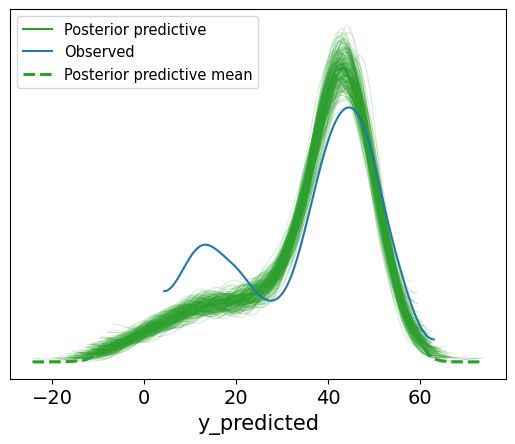

In [16]:
az.plot_ppc(idata_new, num_pp_samples=200, colors=["C2", "C0", "C2"])

This model fits fairly well, but its peak is somewhat higher than the observed data, and it fails to capture the smaller peak on the left as indicated by the posterior predictive check. The linear model reveals a slight exponential curve, which suggests that a simple line is insufficient to fully capture the underlying trend. The failure to account for this curvature may result in the model overestimating certain areas of the data, while underestimating others, particularly where the data deviates from a linear relationship. A more flexible model, potentially incorporating nonlinear terms or transformations, could improve the fit and better reflect the true distribution of the data.

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [17]:
with pm.Model() as bm_new_model:

    intercept = pm.Normal("intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=10)

    # The linear part of our model, but with a twist:
    # Our line is exponentiated to ensure all values are positive
    model_line = pm.Deterministic("model_line", pm.math.exp(intercept + slope * howell.height))

    # Prior for the likelihood's standard deviation
    scale = pm.HalfNormal("scale", 10)

    # Likelihood
    y_predicted = pm.NegativeBinomial("y_predicted", mu=model_line, alpha=scale, observed=howell.weight)

    # Sampling
    ibm_new_data = pm.sample(target_accept=0.99)

Output()

Output()

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'model_line'}>,
        <Axes: title={'center': 'model_line'}>],
       [<Axes: title={'center': 'scale'}>,
        <Axes: title={'center': 'scale'}>],
       [<Axes: title={'center': 'slope'}>,
        <Axes: title={'center': 'slope'}>]], dtype=object)

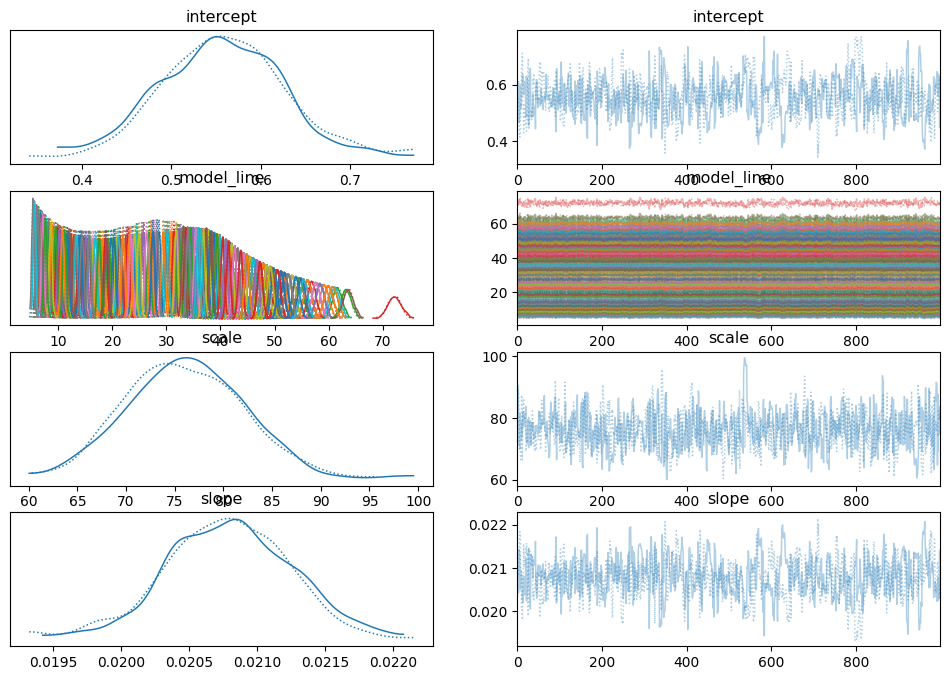

In [18]:
az.rhat(ibm_new_data)
az.plot_trace(ibm_new_data)

Text(0, 0.5, 'weight')

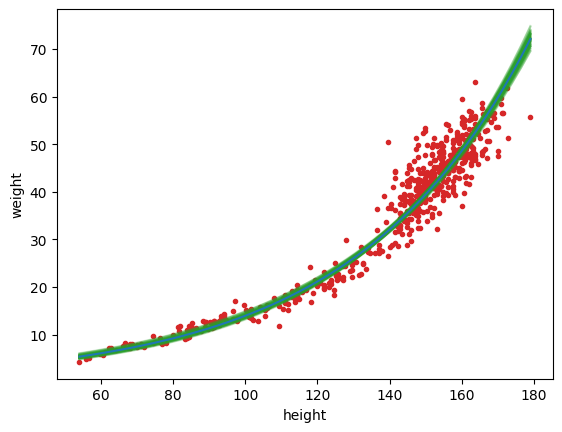

In [19]:
# Grabs 100 posterior samples
posterior_data = az.extract(ibm_new_data, num_samples=100)

# Grabbing x values for graphing.
x_vals_plot = xr.DataArray(
    np.linspace(howell.height.min(), howell.height.max(), 50),
    dims="plot_id"
)

# This creates the expected line, the path we predict temperature and
# rented bike count deviates from
mean_line_new = np.exp(posterior_data["intercept"].mean() + posterior_data["slope"].mean() * x_vals_plot)

# These are 50 lines that our model came up with
lines_new = np.exp(posterior_data["intercept"] + posterior_data["slope"] * x_vals_plot)

# Set up plot
_, ax = plt.subplots()

# Plots 50 other lines our model came up with
ax.plot(x_vals_plot, lines_new.T, c="C2", alpha=0.2, label="lines")

# Plots the mean line
ax.plot(x_vals_plot, mean_line_new, c="C0", label="mean line")

# Plot the raw data
ax.plot(howell.height, howell.weight, "C3.", zorder=-3)

# Label axes and create legend
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

Output()

<Axes: xlabel='y_predicted'>

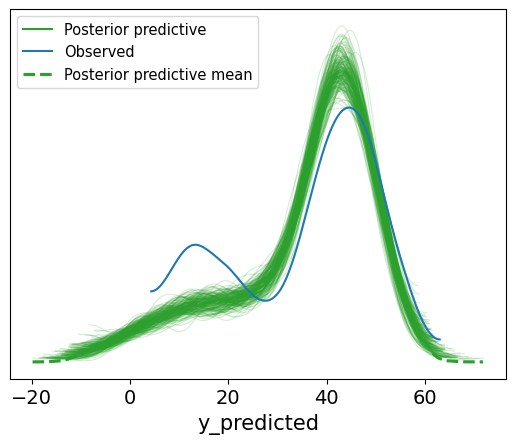

In [31]:
# Ensure posterior predictive samples are generated
with model_new:
    posterior_predictive = pm.sample_posterior_predictive(idata_new, model=model_new, extend_inferencedata=True)

# Now, the `idata_new` should have the posterior predictive group
az.plot_ppc(idata_new, num_pp_samples=200, colors=["C2", "C0", "C2"])

Output()

Text(0, 0.5, 'weight')

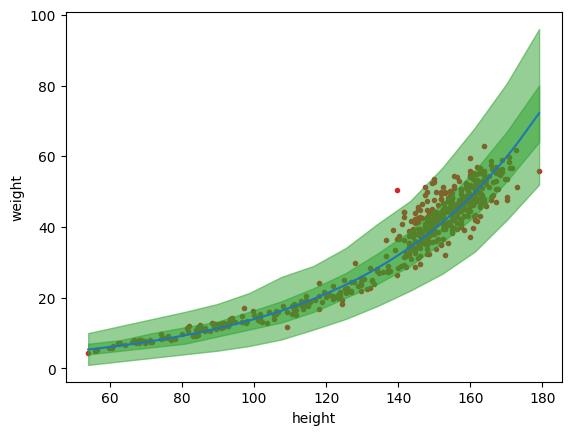

In [32]:
# Sample posterior predictive
pm.sample_posterior_predictive(ibm_new_data, model=bm_new_model, extend_inferencedata=True)

# Grabs the mean line from posterior samples
mean_line_new = ibm_new_data.posterior["model_line"].mean(("chain", "draw"))

# Grabbing heights for graphing
height_values = np.random.normal(howell.height.values, 0.01)
idx_new = np.argsort(height_values)
x_vals = np.linspace(height_values.min(), height_values.max(), 15)

# Grabs the quantiles for the posterior predictive samples
y_pred_quantiles = ibm_new_data.posterior_predictive["y_predicted"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

y_hat_bounds_new = iter(
    [
        PchipInterpolator(height_values[idx_new], y_pred_quantiles[i][idx_new])(x_vals)
        for i in range(4)
    ]
)

# Set up plot
_, ax = plt.subplots()
ax.plot(howell.height, howell.weight, "C3.", zorder=-3)
ax.plot(howell.height[idx_new], mean_line_new[idx_new], c="C0")

# Graph the bounds for posterior predictive distribution
for lb, ub in zip(y_hat_bounds_new, y_hat_bounds_new):
    ax.fill_between(x_vals, lb, ub, color="C2", alpha=0.5)

# Labels for axes
ax.set_xlabel("height")
ax.set_ylabel("weight")

The model fits the observed data well around the central peak, with the posterior predictive mean closely aligning with the observed trend. However, deviations appear in the left tail, where the observed data shows a bump not captured by the model. The predictive draws show tight uncertainty around the peak but wider spread in the tails. While the fit is generally strong, refining the model to better account for the left tail behavior could improve overall performance.